In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = None,
    mask = True))

see one see two 2 2


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 1
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.9567901234567902, Loss: 0.25820668538411456
Checkpoint 200, Accuracy: 0.9629629629629629, Loss: 0.112305897253531
Checkpoint 300, Accuracy: 0.9691358024691358, Loss: 0.10157782943160445
Checkpoint 400, Accuracy: 0.9691358024691358, Loss: 0.10683616002400716
Checkpoint 500, Accuracy: 0.9691358024691358, Loss: 0.10431875122918023


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

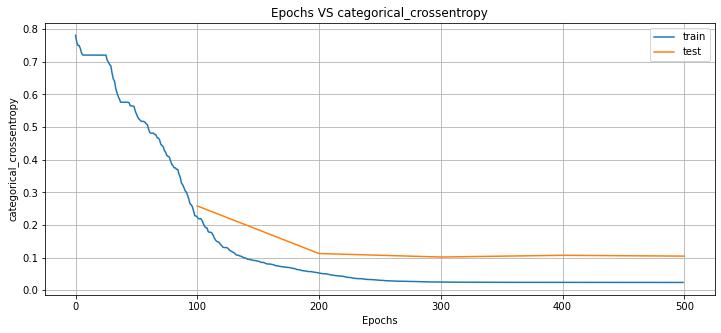

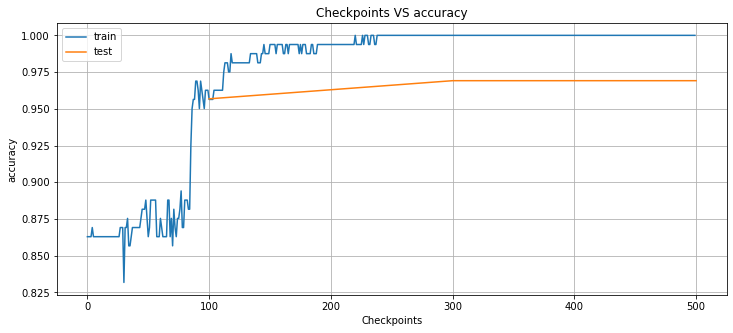

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [12]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.9968047  0.00105376 0.00214147]
[1. 0. 0.] <-> [0.9955456  0.00307153 0.00138281]
[1. 0. 0.] <-> [0.996671   0.00204238 0.00128665]
[0. 1. 0.] <-> [1.1503747e-02 9.8845589e-01 4.0412884e-05]
[0. 0. 1.] <-> [5.7019875e-03 3.9888389e-05 9.9425805e-01]
[0. 0. 1.] <-> [5.7019615e-03 3.9888244e-05 9.9425817e-01]
[1. 0. 0.] <-> [0.9970289  0.00138595 0.00158515]
[1. 0. 0.] <-> [0.996564   0.00139377 0.00204232]
[0. 0. 1.] <-> [6.8911812e-03 4.6845886e-05 9.9306196e-01]
[1. 0. 0.] <-> [0.99629563 0.00130056 0.00240381]
[1. 0. 0.] <-> [0.9970746  0.00139082 0.00153458]
[1. 0. 0.] <-> [0.3321087  0.00118465 0.6667066 ]
[1. 0. 0.] <-> [0.99734384 0.00114803 0.00150817]
[1. 0. 0.] <-> [0.99662054 0.00219448 0.00118494]
[1. 0. 0.] <-> [0.98885274 0.00974254 0.00140466]
[1. 0. 0.] <-> [0.99596703 0.00208504 0.00194799]
[1. 0. 0.] <-> [0.9969796  0.00116502 0.00185539]
[1. 0. 0.] <-> [0.9945372  0.00151519 0.00394769]
[0. 0. 1.] <-> [5.8486117e-03 4.0915020e-05 9.9411041e-01]
[0. 0

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9567901234567902, 'mean_square_error': 0.12686502467653107, 'categorical_crossentropy': 0.25820668538411456, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 6, 'tn_hit': 22, 'fn_hit': 1}, 1: {'tp_hit': 11, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 4}, 2: {'tp_hit': 11, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit': 2}}, 'checkpoint': 100} 


{'accuracy': 0.9629629629629629, 'mean_square_error': 0.06661117594517957, 'categorical_crossentropy': 0.112305897253531, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 5, 'tn_hit': 23, 'fn_hit': 1}, 1: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 3}, 2: {'tp_hit': 11, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit': 2}}, 'checkpoint': 200} 


{'accuracy': 0.9691358024691358, 'mean_square_error': 0.05614826421473899, 'categorical_crossentropy': 0.10157782943160445, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 2, 'tn_hit': 26, 'fn_hit': 3}, 1: {'tp_hit': 14, 'fp_hit': 1, 'tn_hit': 92, 'fn_hit': 1}, 2: {'tp_hit': 12, 'fp_hit': 2, 'tn_hit': 93, '

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[-0.10927248 -3.         -0.14197333  3.          3.        ]
 bias: -2.215360164642334

Neuron 1: weights:
[-0.09630477  3.          0.81274104 -0.55252373 -3.        ]
 bias: 3.0

Neuron 2: weights:
[-1.9166849  3.         2.0472     1.24311   -3.       ]
 bias: -3.0

Neuron 3: weights:
[ 1.936955   -3.         -2.2658153  -0.63716424  2.4040394 ]
 bias: 3.0

$
Layer 2
Neuron 0: weights:
[-3.  3. -3.  3.]
 bias: 0.27659842371940613

Neuron 1: weights:
[-0.99213624  3.          3.         -3.        ]
 bias: -0.6937498450279236

Neuron 2: weights:
[ 3.        -3.        -3.         1.7684323]
 bias: 0.6693530082702637

$

